## Plankton food web grazing fluxes for 2nd cycle 20year climatology

In [1]:
%matplotlib inline
import warnings
warnings.simplefilter("ignore") # Silence warnings
import hvplot.xarray
import xarray as xr
import glob
import pandas as pd
import numpy as np
import os
from pySankey.sankey import sankey
import matplotlib.pyplot as plt

In [2]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [3]:
# ds.z_w/100

In [4]:
graze_ds_inter = np.load("/glade/scratch/gabyn/SPECTRA/graze_ds_inter.npy")

In [5]:
graze_ds_inter.shape

(36, 63, 12, 15, 180, 360)

## Create dataframe

In [8]:
## Gaby's Path 
jluo_path = '/glade/u/home/jluo/cesm_scripts/size_structured/nl_input/cases/g.e21.G1850ECOIAF.t62_g17.marbl0_33.'
gabyn_path = '/glade/u/home/gabyn/case_notes/spectral_cases/g.e21.G1850ECOIAF.t62_g17.marbl0_33.'
nl_config = os.path.join(''+gabyn_path+'GNG595/data/')
sizes = pd.read_csv(nl_config+'plankton_sizes.csv')
sizes = sizes.sort_values('mmolC')
sizes

,type,sname,mass_ugC,vol_um3,ESD_mm,Qp_fixed,mmolC
1,phyto,pp,9.266989e-08,3.706795e-01,0.000891,0.004651,7.715418e-12
2,phyto,mp1,8.241979e-06,1.805089e+01,0.003255,0.006824,6.862025e-10
0,phyto,diaz,5.499929e-05,1.227865e+02,0.006167,0.003333,4.579077e-09
3,phyto,mp2,8.888712e-05,8.790197e+02,0.011885,0.008656,7.400476e-09
6,phyto,diat1,5.004513e-04,1.327390e+04,0.029376,0.010289,4.166608e-08
9,zoo,zoo1,2.803686e-03,2.355042e+04,0.035563,0.008547,2.334265e-07
7,phyto,diat2,3.803133e-03,1.326626e+05,0.063278,0.012602,3.166375e-07
4,phyto,mp3,4.830334e-03,4.280541e+04,0.043401,0.012907,4.021592e-07
8,phyto,diat3,2.890156e-02,1.325863e+06,0.136301,0.015435,2.406258e-06
10,zoo,zoo2,8.933984e-02,7.447577e+05,0.112462,0.008547,7.438168e-06


In [22]:
newNCDFfiles = sorted(glob.glob('/glade/scratch/gabyn/SPECTRA/GNG595_2ndcycle_20year_clim/clim_20yr_GNG595_*', recursive=True),
                      key=numericalSort)

## create a dataframe with the data. 
ds_01 = xr.open_mfdataset(newNCDFfiles,combine='by_coords')

In [23]:
prey_varnames = {}
for i,v in enumerate(sizes.sname):
    prey_varnames[v]=i

In [24]:
pred_varnames = {'zoo1':0,'zoo2':1,'zoo3':2,'zoo4':3,'zoo5':4,'zoo6':5}
grazing_vars = [v for v in ds_01 if 'graze' in v and 'zint' not in v]

In [25]:
graze_split = [v.split('_',3) for v in grazing_vars]
graze_split = pd.DataFrame(graze_split)
graze_split = graze_split.rename({0:'var',1:'prey',2:'pred'}, axis=1)
graze_split['var'] = grazing_vars

In [26]:
grazing_vars
graze_split.head(5)

,var,prey,pred
0,graze_diaz_zoo1,diaz,zoo1
1,graze_diaz_zoo2,diaz,zoo2
2,graze_diaz_zoo3,diaz,zoo3
3,graze_pp_zoo1,pp,zoo1
4,graze_mp1_zoo1,mp1,zoo1


In [27]:
graze_split['prey_ind']=np.nan # add column for the prey idex 
graze_split['pred_ind']=np.nan # add column for the predator idex 
graze_split['val']=np.nan # add column for the grazing value of the predator prey 
graze_split['prop']=np.nan # proportion in each season compared to the annual flux

In [28]:
graze_split

,var,prey,pred,prey_ind,pred_ind,val,prop
0,graze_diaz_zoo1,diaz,zoo1,NaN,NaN,NaN,NaN
1,graze_diaz_zoo2,diaz,zoo2,NaN,NaN,NaN,NaN
2,graze_diaz_zoo3,diaz,zoo3,NaN,NaN,NaN,NaN
3,graze_pp_zoo1,pp,zoo1,NaN,NaN,NaN,NaN
4,graze_mp1_zoo1,mp1,zoo1,NaN,NaN,NaN,NaN
5,graze_mp1_zoo2,mp1,zoo2,NaN,NaN,NaN,NaN
6,graze_mp2_zoo2,mp2,zoo2,NaN,NaN,NaN,NaN
7,graze_mp2_zoo3,mp2,zoo3,NaN,NaN,NaN,NaN
8,graze_mp2_zoo4,mp2,zoo4,NaN,NaN,NaN,NaN
9,graze_mp3_zoo3,mp3,zoo3,NaN,NaN,NaN,NaN


In [29]:
graze_split_cold = np.array(graze_split) 
graze_split_warm = np.array(graze_split) 

In [30]:
graze_ds_inter.shape

(36, 63, 12, 15, 180, 360)

In [ ]:
# cold_years = phytoC_bm_total[cold_years_arctic,:,:,:] # 1/2 standard deviation 
# warm_years = phytoC_bm_total[warm_years_arctic,:,:,:] # 1/2 standard deviation 

In [31]:
cold_years = graze_ds_inter[:,cold_years_arctic,:,:,149:180,:]

In [32]:
warm_years = graze_ds_inter[:,warm_years_arctic,:,:,149:180,:]

In [33]:
cold_yrs = np.nanmean(cold_years,axis=(1,2))
warm_yrs = np.nanmean(warm_years,axis=(1,2))

In [34]:
cold_yrs.shape

(36, 12, 15, 31, 360)

In [35]:
warm_yrs.shape

(36, 12, 15, 31, 360)

In [56]:
graze_cold = np.sum(cold_yrs,axis=2) # I want size (36,12,31,360) (1/2 standard deviation )

In [57]:
graze_warm = np.sum(warm_yrs,axis=2) # I want size (36,12,31,360) (1/2 standard deviation )

In [58]:
graze_cold.shape

(36, 12, 31, 360)

In [59]:
# Annual Cold years
for i in range(len(graze_split.index)):
    graze_split_cold[i,3] = prey_varnames[graze_split_cold[i,1]] # populate index of prey in array 
    graze_split_cold[i,4] = pred_varnames[graze_split_cold[i,2]] # populate idex of predator in array 
    graze_split_cold[i,5] = np.nansum(graze_cold[i,:,:,:]) # add grazing value for corresponding grazing pair(mmol/m^3/s)
    graze_split_cold[i,6] = (np.nansum(graze_cold[i,:,:,:]) / np.sum(graze_split_cold[:,5]))*100 # divide individual grazing to sum of all grazing then divide by 100..
    
df_graze_cold = pd.DataFrame(np.array(graze_split_cold),
                               columns=['var', 'prey','pred','prey_ind','pred_ind','val','prop']) # rename grazing array and convert into dataframe.

In [60]:
# Annual warm years
for i in range(len(graze_split.index)):
    graze_split_warm[i,3] = prey_varnames[graze_split_warm[i,1]] # populate index of prey in array 
    graze_split_warm[i,4] = pred_varnames[graze_split_warm[i,2]] # populate idex of predator in array 
    graze_split_warm[i,5] = np.nansum(graze_warm[i,:,:,:]) # add grazing value for corresponding grazing pair(mmol/m^3/s)
    graze_split_warm[i,6] = (np.nansum(graze_warm[i,:,:,:]) / np.sum(graze_split_warm[:,5]))*100 # divide individual grazing to sum of all grazing then divide by 100..
    
df_graze_warm = pd.DataFrame(np.array(graze_split_warm),
                               columns=['var', 'prey','pred','prey_ind','pred_ind','val','prop']) # rename grazing array and convert into dataframe.

In [61]:
df_graze_cold

,var,prey,pred,prey_ind,pred_ind,val,prop
0,graze_diaz_zoo1,diaz,zoo1,2,0,7.92954e-09,1.16823e-05
1,graze_diaz_zoo2,diaz,zoo2,2,1,1.6777e-10,2.47169e-07
2,graze_diaz_zoo3,diaz,zoo3,2,2,0,0
3,graze_pp_zoo1,pp,zoo1,0,0,0.0030632,4.51289
4,graze_mp1_zoo1,mp1,zoo1,1,0,0.0343631,50.6257
5,graze_mp1_zoo2,mp1,zoo2,1,1,2.41674e-10,3.56049e-07
6,graze_mp2_zoo2,mp2,zoo2,3,1,0.000807513,1.18968
7,graze_mp2_zoo3,mp2,zoo3,3,2,4.67859e-07,0.000689277
8,graze_mp2_zoo4,mp2,zoo4,3,3,0,0
9,graze_mp3_zoo3,mp3,zoo3,7,2,0.000184982,0.272526


In [42]:
graze_split_w_cold = np.array(graze_split)
graze_split_s_cold = np.array(graze_split)
graze_split_w_warm = np.array(graze_split)
graze_split_s_warm = np.array(graze_split)

In [45]:
# Winter Cold
for i in range(len(graze_split.index)):
    graze_split_w_cold[i,3] = prey_varnames[graze_split_w_cold[i,1]] 
    graze_split_w_cold[i,4] = pred_varnames[graze_split_w_cold[i,2]] 
    graze_split_w_cold[i,5] = np.nansum(graze_cold[i, list(range(2)) + [-1],:,:])
    graze_split_w_cold[i,6] = (np.nansum(graze_cold[i, list(range(2)) + [-1],:,:]) / np.sum(graze_split_cold[:,5]))*100

df_graze_winter_cold = pd.DataFrame(np.array(graze_split_w_cold),
                  columns=['var', 'prey','pred','prey_ind','pred_ind','val','prop']) # rename grazing array and convert into dataframe.


# Winter Warm 
for i in range(len(graze_split.index)):
    graze_split_w_warm[i,3] = prey_varnames[graze_split_w_warm[i,1]] 
    graze_split_w_warm[i,4] = pred_varnames[graze_split_w_warm[i,2]] 
    graze_split_w_warm[i,5] = np.nansum(graze_warm[i, list(range(2)) + [-1],:,:])
    graze_split_w_warm[i,6] = (np.nansum(graze_warm[i, list(range(2)) + [-1],:,:]) / np.sum(graze_split_warm[:,5]))*100

df_graze_winter_warm = pd.DataFrame(np.array(graze_split_w_warm),
                  columns=['var', 'prey','pred','prey_ind','pred_ind','val','prop']) # rename grazing array and convert into dataframe.



# Summer Cold
for i in range(len(graze_split.index)):
    graze_split_s_cold[i,3] = prey_varnames[graze_split_s_cold[i,1]] 
    graze_split_s_cold[i,4] = pred_varnames[graze_split_s_cold[i,2]] 
    graze_split_s_cold[i,5] = np.nansum(graze_cold[i, 5:8,:,:])
    graze_split_s_cold[i,6] = (np.nansum(graze_cold[i, 5:8,:,:]) / np.sum(graze_split_cold[:,5]))*100


df_graze_summer_cold = pd.DataFrame(np.array(graze_split_s_cold),
                  columns=['var', 'prey','pred','prey_ind','pred_ind','val','prop']) # rename grazing array and convert into dataframe.

# Summer Warm 
for i in range(len(graze_split.index)):
    graze_split_s_warm[i,3] = prey_varnames[graze_split_s_warm[i,1]] 
    graze_split_s_warm[i,4] = pred_varnames[graze_split_s_warm[i,2]] 
    graze_split_s_warm[i,5] = np.nansum(graze_warm[i, 5:8,:,:])
    graze_split_s_warm[i,6] = (np.nansum(graze_warm[i, 5:8,:,:]) / np.sum(graze_split_warm[:,5]))*100


df_graze_summer_warm = pd.DataFrame(np.array(graze_split_s_warm),
                  columns=['var', 'prey','pred','prey_ind','pred_ind','val','prop']) # rename grazing array and convert into dataframe.



In [46]:
df_graze_summer_warm

,var,prey,pred,prey_ind,pred_ind,val,prop
0,graze_diaz_zoo1,diaz,zoo1,2,0,9.06919e-08,0.000113432
1,graze_diaz_zoo2,diaz,zoo2,2,1,1.12446e-09,1.4064e-06
2,graze_diaz_zoo3,diaz,zoo3,2,2,0,0
3,graze_pp_zoo1,pp,zoo1,0,0,0.00332231,4.15533
4,graze_mp1_zoo1,mp1,zoo1,1,0,0.0278192,34.7945
5,graze_mp1_zoo2,mp1,zoo2,1,1,1.82072e-10,2.27724e-07
6,graze_mp2_zoo2,mp2,zoo2,3,1,0.00065898,0.82421
7,graze_mp2_zoo3,mp2,zoo3,3,2,3.17941e-07,0.000397661
8,graze_mp2_zoo4,mp2,zoo4,3,3,0,0
9,graze_mp3_zoo3,mp3,zoo3,7,2,0.000134847,0.168658


In [47]:
df_graze_cold

,var,prey,pred,prey_ind,pred_ind,val,prop
0,graze_diaz_zoo1,diaz,zoo1,2,0,7.92954e-09,NaN
1,graze_diaz_zoo2,diaz,zoo2,2,1,1.6777e-10,NaN
2,graze_diaz_zoo3,diaz,zoo3,2,2,0,NaN
3,graze_pp_zoo1,pp,zoo1,0,0,0.0030632,NaN
4,graze_mp1_zoo1,mp1,zoo1,1,0,0.0343631,NaN
5,graze_mp1_zoo2,mp1,zoo2,1,1,2.41674e-10,NaN
6,graze_mp2_zoo2,mp2,zoo2,3,1,0.000807513,NaN
7,graze_mp2_zoo3,mp2,zoo3,3,2,4.67859e-07,NaN
8,graze_mp2_zoo4,mp2,zoo4,3,3,0,NaN
9,graze_mp3_zoo3,mp3,zoo3,7,2,0.000184982,NaN


In [62]:
colors = {
    "pp": "#86daf4",
    "diaz": "#60baf7",
    "mp1": "#2d80a4",
    "diat1": "#000140",
    "mp2": "#2d80a4",
    "diat2": "#000140",
    "mp3": "#2d80a4",
    "diat3": "#000140",
    "mp4": "#2d80a4",
    "zoo1": "#FCD19E",
    "zoo2": "#FCD19E",
    "zoo3": "#DE7C08",
    "zoo4": "#DE7C08",
    "zoo5": "#DE7C08",
    "zoo6": "#DE7C08",
}

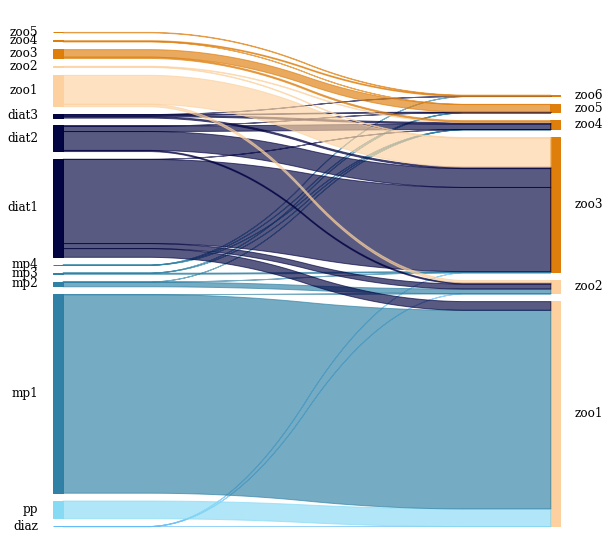

In [63]:
sankey(
    left=df_graze_cold["prey"], right=df_graze_cold["pred"], 
    leftWeight= df_graze_cold["prop"], rightWeight=df_graze_cold["prop"], 
    aspect=20, fontsize=12,colorDict=colors
)
# Get current figure
fig = plt.gcf()

# Set size in inches
fig.set_size_inches(10, 10)

# Set the color of the background to white
fig.set_facecolor("w")
#fig.suptitle('Central Arctic winter average', fontsize=16)

# Save the figure
fig.savefig("/glade/u/home/gabyn/case_notes/analysis_figures/GNG595/food-web_cold_years_AO.png", bbox_inches="tight", dpi=600)


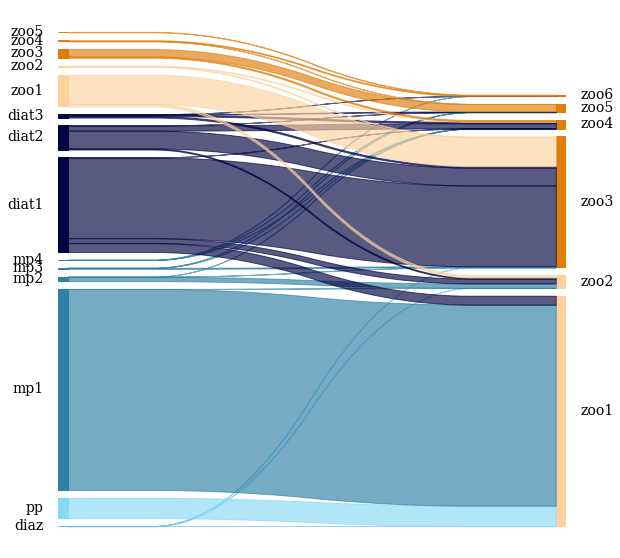

In [64]:
sankey(
    left=df_graze_warm["prey"], right=df_graze_warm["pred"], 
    leftWeight= df_graze_warm["prop"], rightWeight=df_graze_warm["prop"], 
    aspect=20, fontsize=14,colorDict=colors
)
# Get current figure
fig = plt.gcf()

# Set size in inches
fig.set_size_inches(10, 10)

# Set the color of the background to white
fig.set_facecolor("w")
#fig.suptitle('Central Arctic spring average', fontsize=16)

# Save the figure
fig.savefig("/glade/u/home/gabyn/case_notes/analysis_figures/GNG595/food-web_warm_years_AO.png", bbox_inches="tight", dpi=600)


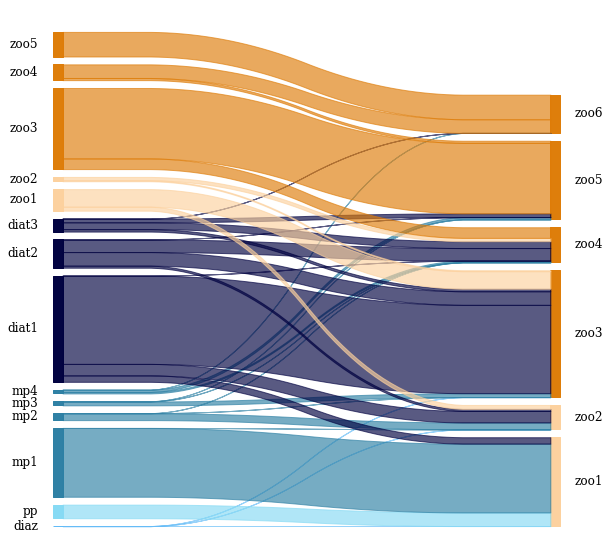

In [51]:
sankey(
    left=df_graze_winter_cold["prey"], right=df_graze_winter_cold["pred"], 
    leftWeight= df_graze_winter_cold["prop"], rightWeight=df_graze_winter_cold["prop"], 
    aspect=20, fontsize=12,colorDict=colors
)
# Get current figure
fig = plt.gcf()

# Set size in inches
fig.set_size_inches(10, 10)

# Set the color of the background to white
fig.set_facecolor("w")
#fig.suptitle('Central Arctic winter average', fontsize=16)

# Save the figure
fig.savefig("/glade/u/home/gabyn/case_notes/analysis_figures/GNG595/food-web_winter_cold_years_AO.png", bbox_inches="tight", dpi=600)


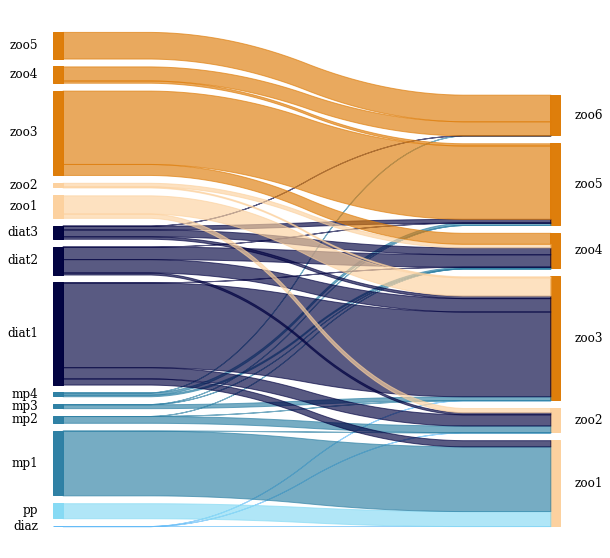

In [52]:
sankey(
    left=df_graze_winter_warm["prey"], right=df_graze_winter_warm["pred"], 
    leftWeight= df_graze_winter_warm["prop"], rightWeight=df_graze_winter_warm["prop"], 
    aspect=20, fontsize=12,colorDict=colors
)
# Get current figure
fig = plt.gcf()

# Set size in inches
fig.set_size_inches(10, 10)

# Set the color of the background to white
fig.set_facecolor("w")
#fig.suptitle('Central Arctic winter average', fontsize=16)

# Save the figure
fig.savefig("/glade/u/home/gabyn/case_notes/analysis_figures/GNG595/food-web_winter_warm_years_AO.png", bbox_inches="tight", dpi=600)



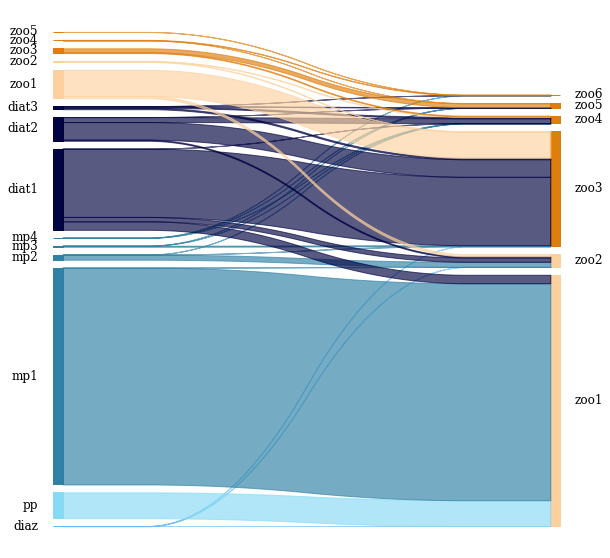

In [53]:
sankey(
    left=df_graze_summer_warm["prey"], right=df_graze_summer_warm["pred"], 
    leftWeight= df_graze_summer_warm["prop"], rightWeight=df_graze_summer_warm["prop"], 
    aspect=20, fontsize=12,colorDict=colors
)
# Get current figure
fig = plt.gcf()

# Set size in inches
fig.set_size_inches(10, 10)

# Set the color of the background to white
fig.set_facecolor("w")
#fig.suptitle('Central Arctic winter average', fontsize=16)

# Save the figure
fig.savefig("/glade/u/home/gabyn/case_notes/analysis_figures/GNG595/food-web_summer_warm_years_AO.png", bbox_inches="tight", dpi=600)




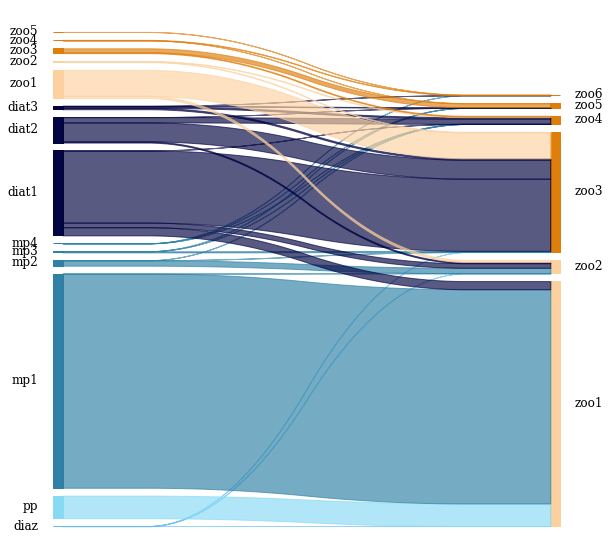

In [54]:
sankey(
    left=df_graze_summer_cold["prey"], right=df_graze_summer_cold["pred"], 
    leftWeight= df_graze_summer_cold["prop"], rightWeight=df_graze_summer_cold["prop"], 
    aspect=20, fontsize=12,colorDict=colors
)
# Get current figure
fig = plt.gcf()

# Set size in inches
fig.set_size_inches(10, 10)

# Set the color of the background to white
fig.set_facecolor("w")
#fig.suptitle('Central Arctic winter average', fontsize=16)

# Save the figure
fig.savefig("/glade/u/home/gabyn/case_notes/analysis_figures/GNG595/food-web_summer_cold_years_AO.png", bbox_inches="tight", dpi=600)


